# Step 2 : pages cleaning and preparation for extraction 

In [2]:
import pandas as pd 
import numpy as np
import tqdm 
from utils.qwen import infer, getTokenCount
from utils.plots import boxplot_token_counts
tqdm.tqdm.pandas()

In [3]:
df1=pd.read_csv("02-extracted-pages.csv")
df2=pd.read_csv("01-data.csv")


## now every article links to its path for verification later 

In [4]:
df1["path"]=df2["path"]
data=df1.copy()
data.sample(1)

,article_id,title,title_en,abstract_ar,abstract_en,general_field,field,authors,authors_en,publish_date,source,page1,page2,path
750,751,NaN,NaN,NaN,NaN,Arabic,NaN,NaN,NaN,NaN,ARPD,مستوى امتلاك طلاب المرحلة المتوسطة بالكويت\nمغ...,مستوى امتلاك طلاب المرحلة المتوسطة بالكويت مها...,finalpdfs/96.pdf


### now getting the token count for each page to see if it needs more cleaning

In [5]:
data["page1_token_count"]=data["page1"].progress_apply(getTokenCount)
data["page2_token_count"]=data["page2"].progress_apply(getTokenCount)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1635/1635 [00:13<00:00, 125.59it/s]


In [6]:
data['total_tokens']=data["page1_token_count"]+data["page2_token_count"]

In [7]:
data.head(1)

,article_id,title,title_en,abstract_ar,abstract_en,general_field,field,authors,authors_en,publish_date,source,page1,page2,path,page1_token_count,page2_token_count,total_tokens
0,1,درجة اكتساب طلبة كلية التربية بجامعة السلطان ق...,The Level of Acquisition of Action Research Sk...,NaN,NaN,NaN,NaN,"[""نور النجار""]",NaN,NaN,AJP,Association of Arab Universities Journal for E...,مجلة اتحاد الجامعات العربية للتربية وعلم النفس...,finalpdfs/AJP_1337_1.pdf,417,682,1099


### box plot to get token count for each page 

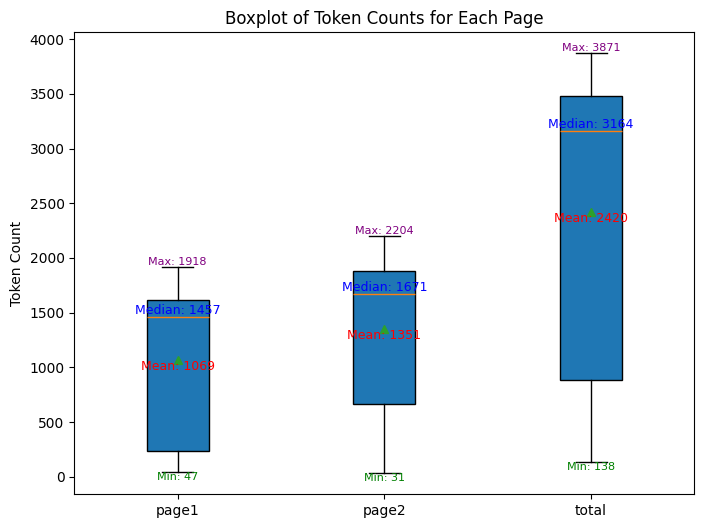

In [8]:
boxplot_token_counts(data)

## Text contain so much ocr noise it needs to be cleaned 

In [9]:
sample = data.head(1)
print("page1 --------------: \n " + sample["page1"].iloc[0])
print("page2 --------------: \n " + sample["page2"].iloc[0])

page1 --------------: 
 Association of Arab Universities Journal for Education and

Psychology
Volume 23 | Issue 2 Article 1
2025

لمهارات البحث الإجرائي وصعوبات تنفيذه من خلال إعدادهم
‎The Level of Acquisition of Action Research‏ .لمشروع التخرجح
‎Skills and Difficulties in its preperarions Through Graduation‏
‎Project Among College of Education Students at Sultan Qaboos‏
‎University‏

نور النجار
‎nour.najar@seciauni.org‏ ,كلية التربية,. جامعة السلطان ‎pools‏ عمان

Follow this and additional works at: https://digitalcommons.aaru.edu.jo/aaru_jep

Digibalrt of the Education Commons
Commons

Network ‏ا‎

Recommended Citation

النجار, نور )2025( "درجة اكتساب طلبة كلية ‎av yall‏ بجامعة السلطان قابوس لمهارات البحث الإجرائي وص 992ب

‎The Level of Acquisition of Action Research Skills and Difficulties in‏ .تنفيذه من خلال إعدادهم لمشروع التخرج
‎its preperarions Through Graduation Project Among College of Education Students at Sultan Qaboos‏
‎University,’ Association of Arab Universities Journal

In [10]:
import re
from pyarabic.araby import strip_tashkeel, strip_tatweel, normalize_alef, normalize_teh

def clean_ocr_and_nonArabic(text: str) -> str:
    """
    Cleans mixed Arabic/English OCR.
    Collapses ALL successive newlines into a single newline.
    """
    if not isinstance(text, str): 
        return ""
    
    # --- A. Arabic Normalization ---
    text = strip_tashkeel(text)
    text = strip_tatweel(text)
    text = normalize_alef(text)
    text = normalize_teh(text)

    # --- B. Fix English Hyphenation ---
    text = re.sub(r'(\w)-\s*\n\s*(\w)', r'\1\2', text)

    # --- C. Remove Layout Artifacts ---
    text = text.replace('|', ' ')
    text = re.sub(r'_{3,}', ' ', text)
    text = re.sub(r'-{3,}', ' ', text)
    text = re.sub(r'^\s*\d+\s*$', '', text, flags=re.MULTILINE)

    # --- D. Filter Garbage ---
    allowed_chars = r'[^\w\s\u0600-\u06FF\.,:;\-\(\)\[\]/@\+\*]'
    text = re.sub(allowed_chars, ' ', text)

    # --- E. Whitespace Management ---
    # 1. Collapse horizontal spaces (tabs, multiple spaces) -> single space
    text = re.sub(r'[ \t]+', ' ', text)
    
    # 2. Collapse ALL successive newlines -> single newline
    # This matches \n followed by any amount of whitespace including other \n
    text = re.sub(r'\n\s*\n*', '\n', text)

    return text.strip()

In [11]:
print(clean_ocr(sample["page1"].iloc[0]))

Association of Arab Universities Journal for Education and
Psychology
Volume 23 Issue 2 Article 1
لمهارات البحث الاجرائي وصعوبات تنفيذه من خلال اعدادهم
The Level of Acquisition of Action Research .لمشروع التخرجح
Skills and Difficulties in its preperarions Through Graduation 
Project Among College of Education Students at Sultan Qaboos 
University 
نور النجار
nour.najar@seciauni.org ,كليه التربيه,. جامعه السلطان pools عمان
Follow this and additional works at: https://digitalcommons.aaru.edu.jo/aaru_jep
Digibalrt of the Education Commons
Commons
Network ا 
Recommended Citation
النجار, نور )2025( درجه اكتساب طلبه كليه av yall بجامعه السلطان قابوس لمهارات البحث الاجرائي وص 992ب
The Level of Acquisition of Action Research Skills and Difficulties in .تنفيذه من خلال اعدادهم لمشروع التخرج
its preperarions Through Graduation Project Among College of Education Students at Sultan Qaboos 
University, Association of Arab Universities Journal for Education and Psychology. Vol. 23: Iss. 2, Article 
.

In [12]:
data["page1"] = data["page1"].progress_apply(clean_ocr)
data["page2"] = data["page2"].progress_apply(clean_ocr)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1635/1635 [00:01<00:00, 1634.26it/s]


### Recalculate and replot

In [13]:
data["page1_token_count"]=data["page1"].progress_apply(getTokenCount)
data["page2_token_count"]=data["page2"].progress_apply(getTokenCount)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1635/1635 [00:13<00:00, 123.90it/s]


In [14]:
data.head(1)

,article_id,title,title_en,abstract_ar,abstract_en,general_field,field,authors,authors_en,publish_date,source,page1,page2,path,page1_token_count,page2_token_count,total_tokens
0,1,درجة اكتساب طلبة كلية التربية بجامعة السلطان ق...,The Level of Acquisition of Action Research Sk...,NaN,NaN,NaN,NaN,"[""نور النجار""]",NaN,NaN,AJP,Association of Arab Universities Journal for E...,مجله اتحاد الجامعات العربيه للتربيه وعلم النفس...,finalpdfs/AJP_1337_1.pdf,382,669,1099


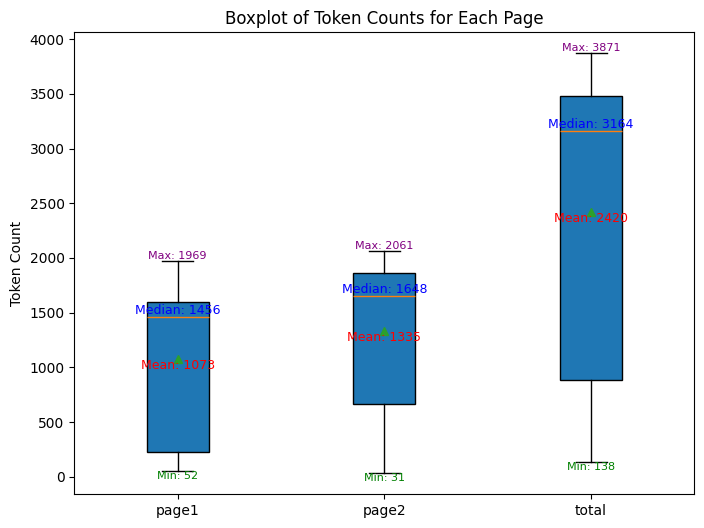

In [22]:
boxplot_token_counts(data)

### token count didnt change but text is normalised so for better accuracy  

In [15]:
data.to_csv("03-pages_cleaned.csv",index=False)